# Galaxy
## Context
The Galaxy Zoo (www.galaxyzoo.org) project start in 2007 when astronomers from Oxford University ask people, in a public way (now at www.galaxyzoo.org/#/classify), to classify their dataset of 1 million galaxies imaged aprox thanks to the SDSS (www.sdss.org/), which is the most detailed three-dimensional maps of the Universe ever made, with deep multi-color images of one third of the sky, and spectra for more than three million astronomical objects. Now with the years, Galaxy Zoo has done differents release which contain a detailed classification of the morphologies (shapes) of galaxies.
 
Galaxies in this set have already been classified once through the help of hundreds of thousands of volunteers, who collectively classified the shapes of these images by eye, so it can contain some bias error. However, this approach becomes less feasible as data sets grow to contain of hundreds of millions (or even billions) of galaxies, so an automatic process is necessary.

**¿Can you classify correctly these images?**

## Content

We present two datasets, a small one to execute in a regular computer and a big one for people with supercomputer.  
This two datasets are composed of the JPG images of galaxies (as inputs) on 5 batchs (*train_batchi.csv.gz*) and the probability distributions derived from human classifications (as target) in one file (*train_labels.csv*). The images are RGB 100x100 pixels, with the galaxy centered and are coming in one row of 30000 columns, the first 10000 columns are the first RGB channel (100x100), the second 10000 columns are the second RGB channel and the last 10000 columns are the last RGB channel.  

The training inputs is in five batchs, 2000 images every batch for the small one dataset and 10000 images every batch for the big one. The test inputs is one file containing 2000 images for the small and 10000 images for the big.

nose: For each galaxy, determine the probability that it belongs in a particular class. Can you write an algorithm that behaves as well as the crowd does?

The labels/target are 11 questions associated to the shape of the galaxy. There is one file for training data and other for test data, the rows on the training data are order as the batch of the images, this mean that the first K rows are for the first batch, the rows K to 2K are the second batch and so on, and the rows in the training and test are orderer. The labels come in the form of the galaxy decision tree of questions (https://data.galaxyzoo.org/gz_trees/gz_trees.html), here we present this:  

**Q1.** Is the galaxy simply smooth and rounded, with no sign of a disk?  
* A1: *Smooth*  

> **Q7**. How rounded is it?
>* A1-3: *Completely round*, *In between* or *Cigar shaped*  

>> Go to Q6

* A2: *Features* or *disk*   

> **Q2.** Could this be a disk viewed edge-on?  
>* A1: *Yes*  

>> **Q9.** Does the galaxy have bulge at its centre? if so, what shape?  
>>* A1-3: *Rounded*, *Boxy* or *No bulge*  

>>> Go to Q6  

>* A2: *No*  

>> **Q3.** Is there a sign of a bar feature through the centre of the galaxy?  
>> * A1: *Bar* or A2- *No bar*  

>>> **Q4.** Is there any sign of a spiral arm pattern?  
>>>* A1: *Spiral*  

>>>> **Q10.** How tightly wound are the spiral arms appear?  
>>>>* A1-3: *Tight*, *Medium* or *Loose*  

>>>>> **Q11**. How many spiral arms are there?  
>>>>>* A1-6: *1*, *2*, *3*, *4*, *More than 4* or *Cant tell*  

>>>>>> Go to Q5  

>>> * A2: *No Spiral*  

>>>> Go to Q5  

>>>>>> **Q5.** How prominent is the central bulge, compared with the rests of the galaxy  
>>>>>> * A1-4: *No bulge*, *Just noticeable*, *Obvious* or *Dominant*  

>>>>>>> Go to Q6  

>>>>>>> **Q6**. Is there anything "odd" about the galaxy?  
>>>>>>>* A1: *Yes*  

>>>>>>>> **Q8.** Is the odd feature a ring, or is the galaxy disturbed or irregular?  
>>>>>>>>>* A1:-7: *Ring*, *Lens or arc*, *Disturbed*, *Irregular*, *Other*, *Merger* or *Dust lane*  - **End**

>>>>>>>* A2: *No* - **End**  

* A3: *Star or artifact* - **End**

But as there are many people that vote any of the possible answer, the dataset has for every image the probability of every answer to every question, this is calculated as the number of people that vote for that answer to that question.  

## Inspiration
Take this huge dataset of images of galaxies, thanks to the Sloan Survey (SDSS), and the common answers of people to questions about their morphology and construct a machine that can learn to detect in a correct way the shape of a galaxy by the JPG image. 

## Acknowledgements
Thanks to Kaggle that hold the Galaxy Zoo competition https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge, also to the Galaxy Zoo project and Sloan that provide all the images.

## Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os,csv
from os import walk
import time
from PIL import Image
from sklearn.metrics import mean_squared_error

def rmse(model,X,y):
    return np.sqrt(mean_squared_error(y,model.predict(X)))

In [2]:
#load all the batch you can, if not you can keep training the model by every batch
#df_train_batch1 = pd.read_csv("GalaxyZoo_kaggle/dataset_grande//train_batch1.csv.gz",header=None)
#df_train_batch2 = pd.read_csv("GalaxyZoo_kaggle/dataset_grande/train_batch2.csv.gz",header=None)
#df_train_batch3 = pd.read_csv("GalaxyZoo_kaggle/dataset_grande/train_batch3.csv.gz",header=None)
#df_train_batch4 = pd.read_csv("GalaxyZoo_kaggle/dataset_grande/train_batch4.csv.gz",header=None)
df_train_batch5 = pd.read_csv("GalaxyZoo_kaggle/dataset_grande/train_batch5.csv.gz",header=None)
df_train = pd.concat([df_train_batch5],axis=0)

#df_test = pd.read_csv("GalaxyZoo_kaggle/dataset_grande/test.csv.gz",header=None)
print("Dimensiones training: ",df_train.shape)
#print("Dimensiones test: ",df_test.shape)
#df_test.head()

('Dimensiones training: ', (10000, 30000))


In [2]:
train_labels = pd.read_csv("GalaxyZoo_kaggle/dataset_grande/train_labels.csv")
test_labels = pd.read_csv("GalaxyZoo_kaggle/dataset_grande/test_labels.csv")
train_labels.head()

,GalaxyID,Answer1.1,Answer1.2,Answer1.3,Answer2.1,Answer2.2,Answer3.1,Answer3.2,Answer4.1,Answer4.2,...,Answer9.3,Answer10.1,Answer10.2,Answer10.3,Answer11.1,Answer11.2,Answer11.3,Answer11.4,Answer11.5,Answer11.6
0,569297,0.083065,0.916935,0.000000,0.023551,0.893384,0.107109,0.786276,0.714189,0.179195,...,0.000000,0.459257,0.254932,0.000000,0.000000,0.504446,0.000000,0.0,0.0,0.209744
1,701332,0.275109,0.713127,0.011765,0.633523,0.079604,0.079604,0.000000,0.000000,0.079604,...,0.499005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
2,908039,0.411643,0.587223,0.001134,0.234878,0.352345,0.000000,0.352345,0.205471,0.146874,...,0.026647,0.205471,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.205471
3,401459,0.013316,0.986684,0.000000,0.000000,0.986684,0.753419,0.233265,0.986684,0.000000,...,0.000000,0.350273,0.381847,0.254564,0.191225,0.508621,0.095613,0.0,0.0,0.191225
4,607293,0.829407,0.128859,0.041733,0.021519,0.107340,0.000000,0.107340,0.000000,0.107340,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000


In [4]:
!ls Descargas/

darg_mergers.csv	     GalaxyZoo1_DR_table5.csv.gz
GalaxyZoo1_DR_table2.csv.gz  GalaxyZoo1_DR_table6.csv.gz
GalaxyZoo1_DR_table3.csv.gz  GalaxyZoo1_DR_table7.csv.gz
GalaxyZoo1_DR_table4.csv.gz  schawinski_GZ_2010_catalogue.fits.gz


In [28]:
aux = pd.read_csv("./Descargas/GalaxyZoo1_DR_table3.csv.gz")
print(aux.shape)
aux.head()

(225268, 11)


,OBJID,RA,DEC,NVOTE,P_EL,P_CW,P_ACW,P_EDGE,P_DK,P_MG,P_CS
0,587730774425665700,00:00:01.28,+15:04:40.8,73,0.479,0.000,0.000,0.014,0.479,0.027,0.014
1,587727220876640877,00:00:01.86,+14:01:28.2,29,0.655,0.000,0.000,0.000,0.345,0.000,0.000
2,587727180060098742,00:00:02.15,-09:31:37.0,30,0.467,0.000,0.033,0.000,0.467,0.033,0.033
3,588015509806252142,00:00:02.28,+00:37:39.2,29,0.655,0.034,0.034,0.103,0.172,0.000,0.172
4,587731187277627683,00:00:02.96,+00:43:04.8,24,0.583,0.000,0.083,0.167,0.125,0.042,0.250


In [3]:
X_train = df_train.values.reshape((df_train.shape[0],3,100,100))
X_train = X_train.transpose([0,2, 3, 1])
aux = X_train.astype(np.uint8) #'uint'

output = open('traindata.npy','ab')
np.save(output, aux)
output.close()
print("guardado.")

guardado.


In [5]:
aux = np.load('traindata.npy')
print(aux.dtype)
aux

uint8


array([[[[ 6,  6,  6],
         [ 3,  3,  3],
         [ 0,  0,  0],
         ...,
         [ 5,  5,  5],
         [ 2,  2,  2],
         [ 0,  0,  0]],

        [[10, 10, 10],
         [ 1,  1,  1],
         [ 1,  1,  1],
         ...,
         [ 5,  5,  5],
         [ 1,  1,  1],
         [ 1,  1,  1]],

        [[ 4,  4,  4],
         [ 0,  0,  0],
         [ 2,  2,  2],
         ...,
         [ 1,  1,  1],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        ...,

        [[ 2,  2,  2],
         [ 4,  4,  4],
         [ 3,  3,  3],
         ...,
         [ 2,  2,  2],
         [ 3,  4,  3],
         [ 2,  4,  3]],

        [[ 2,  2,  2],
         [ 5,  5,  5],
         [ 5,  5,  5],
         ...,
         [ 3,  3,  3],
         [ 1,  2,  2],
         [ 1,  3,  2]],

        [[ 1,  1,  1],
         [ 1,  1,  1],
         [ 1,  1,  1],
         ...,
         [ 1,  1,  1],
         [ 0,  2,  1],
         [ 1,  3,  2]]],


       [[[ 4,  4,  2],
         [ 4,  4,  2],
         [ 6, 

In [7]:
aux.shape

(10000, 100, 100, 3)

In [4]:
#aux.astype('')
aux = aux/255.0
print(aux.shape)
aux

(10000, 100, 100, 3)


array([[[[0.02352941, 0.02352941, 0.02352941],
         [0.01176471, 0.01176471, 0.01176471],
         [0.        , 0.        , 0.        ],
         ...,
         [0.01960784, 0.01960784, 0.01960784],
         [0.00784314, 0.00784314, 0.00784314],
         [0.        , 0.        , 0.        ]],

        [[0.03921569, 0.03921569, 0.03921569],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         ...,
         [0.01960784, 0.01960784, 0.01960784],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157]],

        [[0.01568627, 0.01568627, 0.01568627],
         [0.        , 0.        , 0.        ],
         [0.00784314, 0.00784314, 0.00784314],
         ...,
         [0.00392157, 0.00392157, 0.00392157],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.00784314, 0.00784314, 0.00784314],
         [0.01568627, 0.01568627, 0.01568627]

In [14]:
test_labels.columns

Index([  u'GalaxyID',  u'Answer1.1',  u'Answer1.2',  u'Answer1.3',
        u'Answer2.1',  u'Answer2.2',  u'Answer3.1',  u'Answer3.2',
        u'Answer4.1',  u'Answer4.2',  u'Answer5.1',  u'Answer5.2',
        u'Answer5.3',  u'Answer5.4',  u'Answer6.1',  u'Answer6.2',
        u'Answer7.1',  u'Answer7.2',  u'Answer7.3',  u'Answer8.1',
        u'Answer8.2',  u'Answer8.3',  u'Answer8.4',  u'Answer8.5',
        u'Answer8.6',  u'Answer8.7',  u'Answer9.1',  u'Answer9.2',
        u'Answer9.3', u'Answer10.1', u'Answer10.2', u'Answer10.3',
       u'Answer11.1', u'Answer11.2', u'Answer11.3', u'Answer11.4',
       u'Answer11.5', u'Answer11.6'],
      dtype='object')

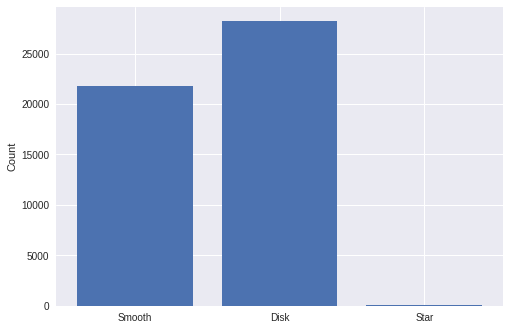

In [4]:
y_train = train_labels.iloc[:,1:4].values #only the first question
aux = np.argmax(y_train,axis=1)
plt.bar([1,2,3],np.bincount(aux))
plt.xticks([1,2,3],["Smooth","Disk","Star"])
plt.ylabel("Count")
plt.show()

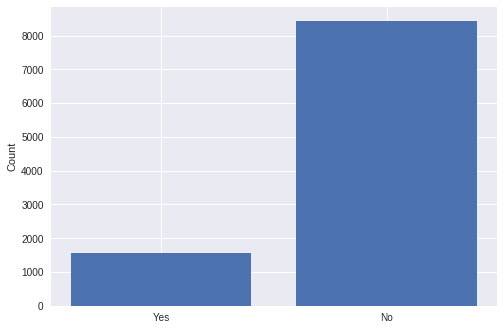

In [7]:
y_train = train_labels.iloc[:,4:6].values #only the second question
aux = np.argmax(y_train,axis=1)
plt.bar([1,2],np.bincount(aux))
plt.xticks([1,2],["Yes","No"])
plt.ylabel("Count")
plt.show()

First we need to reshape the rows of the data to retrieve the shape of the images (the 3 chanels of 100x100 pixels images).

In [ ]:
reshape((.,3,100,100))

### Create data as input

As the data come in rows, we have to reshape to recover the original 3 channels matrix array of the jpg image and then we normalize between 0 and 1, also we transpose the matrix to have the shape accepted by the tensorflow backend (x,y,chanels).  

In [3]:
#normalize between 0 and 1
X_test = df_test.values.reshape((df_test.shape[0],3,100,100))/255.0 
X_train = df_train.values.reshape((df_train.shape[0],3,100,100))/255.0 

#Transpose to tensorflow dimension, the 3 chanels are the last shape
X_test = X_test.transpose([0,2, 3, 1])
X_train = X_train.transpose([0,2, 3, 1])

## Train CNN

In [3]:
import keras
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,concatenate,Input,Activation,Input
from keras import regularizers

For this first analysis we are going to consider only the first question **Q1** and the 3 possible answers.

In [6]:
y_test = test_labels.iloc[:,1:4].values
y_train = train_labels.iloc[-2000:,1:4].values #only the first question Q1

We define our Convolutional neural network to have 2 layers of convolutions + pooling and a final dense layer (feed forward). You can try your own configuration of the network, more kernels on the channels, a big size of the kernel or more deep.

In [7]:
#if not first batch, load model
#model_q1 = load_model('./train_models/cnn_q1_regularized.h5')

model_q1 = load_model('./train_models/cnn_q1_deeper_regularized.h5')

#model_q1 = load_model('./train_models/cnn_q1_lightdeeper_regularized.h5')

"""
model_q1 = Sequential()
model_q1.add(Conv2D( 32, (3, 3) , padding='same', input_shape=X_train.shape[1:], activation='relu',kernel_regularizer=regularizers.l2(0.0005)))
model_q1.add(Conv2D( 32, (3, 3), padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.0005)))
model_q1.add(MaxPooling2D(pool_size=(2, 2)))
#model_q1.add(Dropout(0.25))

model_q1.add(Conv2D( 64, (3, 3), padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.0005)))
model_q1.add(Conv2D( 64, (3, 3), padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.0005)))
model_q1.add(MaxPooling2D(pool_size=(2, 2)))
#model_q1.add(Dropout(0.25))

#una capa mas
#model_q1.add(Conv2D( 64, (3, 3), padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.0005)))
#model_q1.add(MaxPooling2D(pool_size=(2, 2)))
#model_q1.add(Dropout(0.25))

model_q1.add(Flatten())
model_q1.add(Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.005)))
model_q1.add(Dense(256,activation='relu',kernel_regularizer=regularizers.l2(0.005)))
#model_q1.add(Dropout(0.3))

model_q1.add(Dense(y_test.shape[1],activation='softmax'))
"""

model_q1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 40000)             0         
__________

In [16]:
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras import backend as K

def global_average_pooling(x):
    return K.mean(x, axis = (1, 2))

def global_average_pooling_shape(input_shape):
    return (None,input_shape[-1])

sub_model = Model(model_q1.layers[0].input,model_q1.layers[-6].output)
sub_modelsequential = Sequential(layers=sub_model.layers)


sub_modelsequential.add(Lambda(global_average_pooling, output_shape=global_average_pooling_shape))
sub_modelsequential.add(Dense(y_test.shape[1],activation='softmax'))
sub_modelsequential.compile( optimizer='adam', loss='kullback_leibler_divergence' ,metrics=['acc']) 
sub_modelsequential.summary()

sub_modelsequential.fit(X_train, y_train,batch_size=64,epochs=15,validation_data=(X_test, y_test),verbose=1)

(None, 50, 50, 64)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 64)        36928     
_________________________________________________________________
lambda_4 (Lambda)            (None, 64)                0 

In [75]:
img= [X_test[5]]

#Get the 50 input weights to the softmax.
class_weights = sub_modelsequential.layers[-1].get_weights()[0]

final_conv_layer = sub_modelsequential.layers[-3] #conv2d_4

get_output = K.function([sub_modelsequential.layers[0].input], [final_conv_layer.get_output_at(0),sub_modelsequential.layers[-1].output])

[conv_outputs, predictions] = get_output([img])
conv_outputs = conv_outputs[0, :, :, :]

#Create the class activation map.
cam_0 = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])
target_class = 0
for i, w in enumerate(class_weights[:, target_class]):
        cam_0 += w * conv_outputs[:, :, i]
cam_1 = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])
target_class = 1
for i, w in enumerate(class_weights[:, target_class]):
        cam_1 += w * conv_outputs[:, :, i]
cam_2 = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])
target_class = 2
for i, w in enumerate(class_weights[:, target_class]):
        cam_2 += w * conv_outputs[:, :, i]

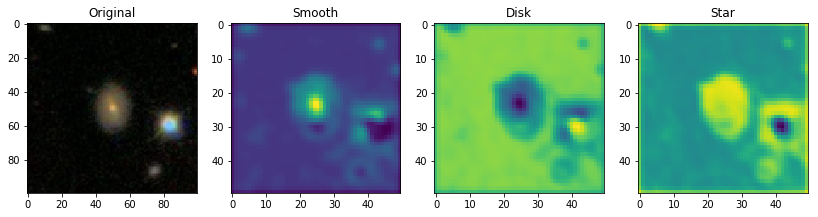

In [76]:
f, axarr = plt.subplots(1,4,figsize=(14,8))
axarr[0].imshow(img[0])
axarr[0].set_title('Original')
axarr[1].imshow(cam_0)
axarr[1].set_title('Smooth')

axarr[2].imshow(cam_1)
axarr[2].set_title('Disk')

axarr[3].imshow(cam_2)
axarr[3].set_title('Star')
plt.show()

We train the model by the loss function KL-divergence because we have probabilities as outputs, so we need to minimize the *distance* or divergence between these two proabilities (the real value and the predicted).

In [8]:
#model_q1.compile( optimizer='adam', loss='categorical_crossentropy' ,metrics=['acc'])
model_q1.compile( optimizer='adam', loss='kullback_leibler_divergence' ,metrics=['acc']) 

#hist1 = model.fit(X_train, y_train,batch_size=50,epochs=10,validation_data=(X_test, y_test),verbose=1)
model_q1.fit(X_train, y_train,batch_size=64,epochs=15,validation_data=(X_test, y_test),verbose=1)

Train on 4000 samples, validate on 2000 samples
Epoch 1/15
4000/4000 [==============================] - 82s - loss: 1.5078 - acc: 0.6060 - val_loss: 0.4837 - val_acc: 0.5975
Epoch 2/15
4000/4000 [==============================] - 75s - loss: 0.3509 - acc: 0.7087 - val_loss: 0.2649 - val_acc: 0.7545
Epoch 3/15
4000/4000 [==============================] - 74s - loss: 0.2467 - acc: 0.7475 - val_loss: 0.2430 - val_acc: 0.7670
Epoch 4/15
4000/4000 [==============================] - 74s - loss: 0.2209 - acc: 0.7640 - val_loss: 0.2172 - val_acc: 0.7600
Epoch 5/15
4000/4000 [==============================] - 76s - loss: 0.1990 - acc: 0.7742 - val_loss: 0.1901 - val_acc: 0.7750
Epoch 6/15
4000/4000 [==============================] - 75s - loss: 0.1882 - acc: 0.7818 - val_loss: 0.1835 - val_acc: 0.7960
Epoch 7/15
4000/4000 [==============================] - 75s - loss: 0.1811 - acc: 0.7825 - val_loss: 0.1796 - val_acc: 0.7650
Epoch 8/15
4000/4000 [==============================] - 74s - loss: 0.

In [9]:
#last- batch5
model_q1.fit(X_train, y_train,batch_size=64,epochs=15,validation_data=(X_test, y_test),verbose=1)

Train on 2000 samples, validate on 2000 samples
Epoch 1/15
2000/2000 [==============================] - 54s - loss: 0.1342 - acc: 0.8100 - val_loss: 0.1292 - val_acc: 0.8135
Epoch 2/15
2000/2000 [==============================] - 42s - loss: 0.1367 - acc: 0.8080 - val_loss: 0.1379 - val_acc: 0.8230
Epoch 3/15
2000/2000 [==============================] - 42s - loss: 0.1419 - acc: 0.8000 - val_loss: 0.1395 - val_acc: 0.8040
Epoch 4/15
2000/2000 [==============================] - 42s - loss: 0.1305 - acc: 0.8295 - val_loss: 0.1382 - val_acc: 0.8250
Epoch 5/15
2000/2000 [==============================] - 42s - loss: 0.1221 - acc: 0.8310 - val_loss: 0.1301 - val_acc: 0.8285
Epoch 6/15
2000/2000 [==============================] - 42s - loss: 0.1187 - acc: 0.8310 - val_loss: 0.1454 - val_acc: 0.8130
Epoch 7/15
2000/2000 [==============================] - 42s - loss: 0.1163 - acc: 0.8370 - val_loss: 0.1380 - val_acc: 0.8080
Epoch 8/15
2000/2000 [==============================] - 42s - loss: 0.

### Data Augmentation
In a regularized way we can use keras to do data augmentation by rotate, zooming, shift the galaxies images and train in that news images generated by that.

In [10]:
from keras.preprocessing import image
datagen = image.ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each input by its std
    zca_whitening=False, # apply ZCA whitening
    zoom_range=[0.6,1.4],
    rotation_range=180, # randomly rotate images (degrees, 0 to 180)
    width_shift_range=0.1, # randomly shift images horizontally (fraction of width)
    height_shift_range=0.1, # randomly shift images vertically (fraction of height)
    horizontal_flip=True, # randomly flip images
    vertical_flip=True) # randomly flip images
datagen.fit(X_train)

model_q1.fit_generator(datagen.flow(X_train, y_train,batch_size=100),
        steps_per_epoch=X_train.shape[0]// 100,
        epochs=10,validation_data=(X_test, y_test),verbose=1)

Epoch 1/10
20/20 [==============================] - 40s - loss: 0.1824 - acc: 0.7485 - val_loss: 0.1568 - val_acc: 0.7935
Epoch 2/10
20/20 [==============================] - 36s - loss: 0.1665 - acc: 0.7805 - val_loss: 0.1664 - val_acc: 0.7995
Epoch 3/10
20/20 [==============================] - 36s - loss: 0.1602 - acc: 0.7755 - val_loss: 0.1391 - val_acc: 0.8145
Epoch 4/10
20/20 [==============================] - 36s - loss: 0.1526 - acc: 0.7835 - val_loss: 0.1361 - val_acc: 0.8285
Epoch 5/10
20/20 [==============================] - 36s - loss: 0.1528 - acc: 0.7870 - val_loss: 0.1610 - val_acc: 0.7800
Epoch 6/10
20/20 [==============================] - 36s - loss: 0.1502 - acc: 0.7910 - val_loss: 0.1473 - val_acc: 0.7945
Epoch 7/10
20/20 [==============================] - 36s - loss: 0.1505 - acc: 0.7885 - val_loss: 0.1371 - val_acc: 0.8240
Epoch 8/10
20/20 [==============================] - 36s - loss: 0.1487 - acc: 0.7905 - val_loss: 0.1351 - val_acc: 0.8215
Epoch 9/10
20/20 [======

In [12]:
#save model
model_q1.save('./train_models/cnn_q1_deeper_regularized1.h5')

Now when we have our model train in all the batch that we want we can give predict the first question that we choose.

In [12]:
X_test = pd.read_csv("GalaxyZoo_kaggle/dataset_chico/test.csv.gz",header=None).values
X_test = X_test.reshape((X_test.shape[0],3,100,100))/255.0 
X_test = X_test.transpose([0,2, 3, 1])
y_test = pd.read_csv("GalaxyZoo_kaggle/dataset_chico/test_labels.csv").iloc[:,1:4].values

In [19]:
#default
score = model_q1.evaluate(X_test,y_test,verbose=0)
print("The error in the test set is of %f"%(1-score[1]))
print("The root mean squared error on the first level (Q1) is %f"%rmse(model_q1,X_test,y_test))

The error in the test set is of 0.229500
The root mean squared error on the first level (Q1) is 0.185767


In [13]:
#regularized
score = model_q1.evaluate(X_test,y_test,verbose=0)
print("The error in the test set is of %f"%(1-score[1]))
print("The root mean squared error on the first level (Q1) is %f"%rmse(model_q1,X_test,y_test))

The error in the test set is of 0.191000
The root mean squared error on the first level (Q1) is 0.164355


In [12]:
#deeper-regularized
score = model_q1.evaluate(X_test,y_test,verbose=0)
print("The error in the test set is of %f"%(1-score[1]))
print("The root mean squared error on the first level (Q1) is %f"%rmse(model_q1,X_test,y_test))

The error in the test set is of 0.162500
The root mean squared error on the first level (Q1) is 0.146903


In [14]:
from random import randint
label_names = ["Smooth","Disk","Star"]
def visualize_outputs(X,Y,model):
    n = randint(0,X.shape[0])
    aux = X[n]
    canal_r = aux[:,:,0]
    canal_g = aux[:,:,1]
    canal_b = aux[:,:,2]
    
    f,ax = plt.subplots(1,2,figsize=(8,3))
    ax[0].set_title("Most voted by people: %s (with %.3f of certain)"%(label_names[np.argmax(Y[n])],np.max(Y[n])))

    ax[0].imshow(aux)
    ax[0].set_yticks([])
    ax[0].set_xticks([])

    ax[1].imshow(canal_r, interpolation="bicubic")
    ax[1].imshow(canal_g, interpolation="bicubic")
    ax[1].imshow(canal_b, interpolation="bicubic")
    ax[1].set_yticks([])
    ax[1].set_xticks([])
    plt.show()
    probabilities = model.predict(np.asarray([aux]),verbose=0)[0]
    print("Expected by the model: %s "%label_names[np.argmax(probabilities)])
    for label,p in zip(label_names,probabilities):
        print("Probability for %s is: %.3f"%(label,p))

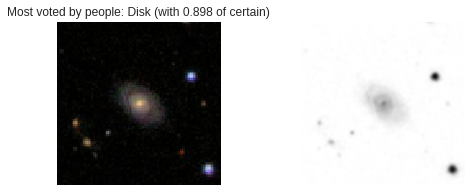

Expected by the model: Disk 
Probability for Smooth is: 0.298
Probability for Disk is: 0.686
Probability for Star is: 0.016


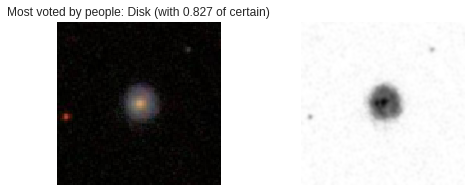

Expected by the model: Disk 
Probability for Smooth is: 0.181
Probability for Disk is: 0.808
Probability for Star is: 0.011


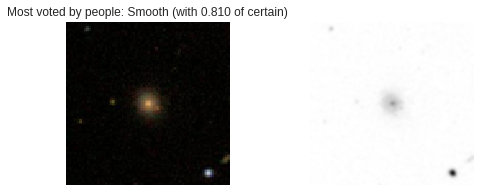

Expected by the model: Smooth 
Probability for Smooth is: 0.595
Probability for Disk is: 0.374
Probability for Star is: 0.031


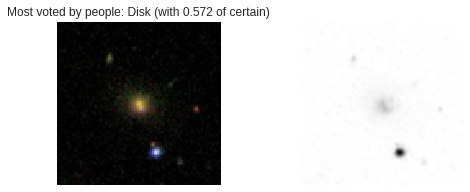

Expected by the model: Smooth 
Probability for Smooth is: 0.661
Probability for Disk is: 0.306
Probability for Star is: 0.033


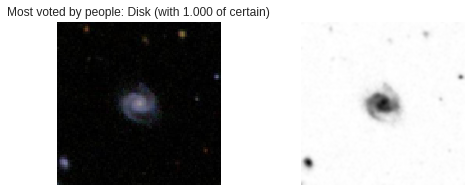

Expected by the model: Disk 
Probability for Smooth is: 0.110
Probability for Disk is: 0.884
Probability for Star is: 0.006


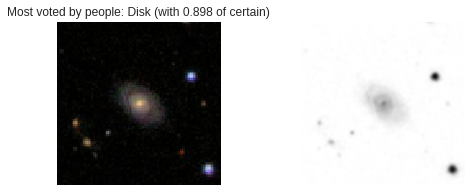

Expected by the model: Disk 
Probability for Smooth is: 0.298
Probability for Disk is: 0.686
Probability for Star is: 0.016


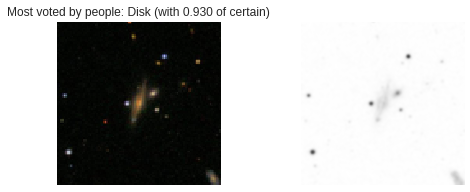

Expected by the model: Disk 
Probability for Smooth is: 0.285
Probability for Disk is: 0.697
Probability for Star is: 0.018


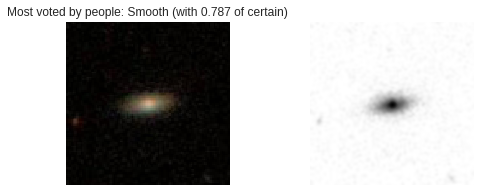

Expected by the model: Disk 
Probability for Smooth is: 0.484
Probability for Disk is: 0.492
Probability for Star is: 0.024


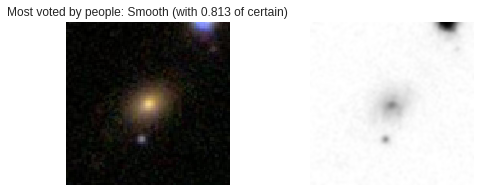

Expected by the model: Smooth 
Probability for Smooth is: 0.711
Probability for Disk is: 0.258
Probability for Star is: 0.032


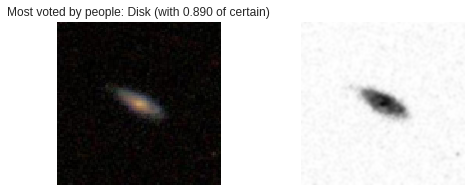

Expected by the model: Disk 
Probability for Smooth is: 0.159
Probability for Disk is: 0.831
Probability for Star is: 0.010


In [15]:
for i in range(10):
    visualize_outputs(X_test,y_test,model_q1)

### One model per Question

Now as we have train a good model to predict the first question (RMSE of 0.18) we can train a different model to focus on the differents levels of question in the tree of questions.

In [38]:
#normalize to sum 1
from keras.activations import softmax
import tensorflow as tf

def my_softmax(a):
    a_as_tensor = tf.convert_to_tensor(a)
    return tf.Session().run(softmax(a_as_tensor))

In [8]:
#second tier of questions ( Q2)
y_test = test_labels.iloc[:,4:6].values
y_train = train_labels.iloc[-2000:,4:6].values 

print("Old")
print(y_test)
print("New")
print(my_softmax(y_test))

Old
[[ 0.          0.434101  ]
 [ 0.          0.13364   ]
 [ 0.          0.414261  ]
 ..., 
 [ 0.          0.958213  ]
 [ 0.32869243  0.30849857]
 [ 0.          0.226901  ]]
New
[[ 0.39314748  0.60685252]
 [ 0.46663964  0.53336036]
 [ 0.39789085  0.60210915]
 ..., 
 [ 0.27723612  0.72276388]
 [ 0.50504829  0.49495171]
 [ 0.44351687  0.55648313]]


In [9]:
y_test = my_softmax(y_test)
y_train = my_softmax(y_train)

In [10]:
model_q2 = load_model('./train_models/cnn_q2_deeper_regularized.h5')

"""
image_inputs = Input(shape=X_train.shape[1:])
x = Conv2D( 32, (3, 3) , padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.0005))(image_inputs)
x = Conv2D( 32, (3, 3) , padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.0005))(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D( 64, (3, 3), padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.0005))(x)
x = Conv2D( 64, (3, 3), padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.0005))(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.005))(x)
out1 = Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.005))(x)

q1_inputs = Input(shape=(3,))
out2 = Activation('linear')(q1_inputs)

aux = concatenate([out1, out2]) 
out3 = Dense(y_test.shape[1],activation='softmax')(aux)

model_q2 = Model(inputs=[image_inputs, q1_inputs], outputs=out3)
"""

model_q2.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 100, 100, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 100, 100, 32)  896         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 100, 100, 32)  9248        conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 50, 50, 32)    0           conv2d_2[0][0]                   
___________________________________________________________________________________________

In [11]:
#answer_q1_train = model_q1.predict(X_train)
answer_q1_test = model_q1.predict(X_test)

#teacher_forcing
answer_q1_train = train_labels.iloc[-2000:,1:4].values
#answer_q1_test = test_labels.iloc[:,1:4].values

We use a small batch size so it can fit the GPU size.

In [12]:
model_q2.compile( optimizer='adam', loss='kullback_leibler_divergence')

model_q2.fit([X_train,answer_q1_train], y_train,batch_size=20,epochs=10,
             validation_data=([X_test,answer_q1_test], y_test),verbose=1)

Train on 4000 samples, validate on 2000 samples
Epoch 1/10
4000/4000 [==============================] - 129s - loss: 0.3205 - val_loss: 0.0281
Epoch 2/10
4000/4000 [==============================] - 124s - loss: 0.0228 - val_loss: 0.0240
Epoch 3/10
4000/4000 [==============================] - 124s - loss: 0.0201 - val_loss: 0.0230
Epoch 4/10
4000/4000 [==============================] - 124s - loss: 0.0191 - val_loss: 0.0226
Epoch 5/10
4000/4000 [==============================] - 124s - loss: 0.0177 - val_loss: 0.0214
Epoch 6/10
4000/4000 [==============================] - 124s - loss: 0.0168 - val_loss: 0.0192
Epoch 7/10
4000/4000 [==============================] - 124s - loss: 0.0154 - val_loss: 0.0170
Epoch 8/10
4000/4000 [==============================] - 124s - loss: 0.0150 - val_loss: 0.0172
Epoch 9/10
4000/4000 [==============================] - 124s - loss: 0.0144 - val_loss: 0.0171
Epoch 10/10
4000/4000 [==============================] - 124s - loss: 0.0140 - val_loss: 0.0154


In [12]:
#if not first batch, keep training
model_q2.fit([X_train,answer_q1_train], y_train,batch_size=20,epochs=10,
             validation_data=([X_test,answer_q1_test], y_test),verbose=1)

Train on 2000 samples, validate on 2000 samples
Epoch 1/10
2000/2000 [==============================] - 71s - loss: 0.0118 - val_loss: 0.0138
Epoch 2/10
2000/2000 [==============================] - 69s - loss: 0.0122 - val_loss: 0.0142
Epoch 3/10
2000/2000 [==============================] - 68s - loss: 0.0122 - val_loss: 0.0140
Epoch 4/10
2000/2000 [==============================] - 68s - loss: 0.0121 - val_loss: 0.0145
Epoch 5/10
2000/2000 [==============================] - 68s - loss: 0.0122 - val_loss: 0.0138
Epoch 6/10
2000/2000 [==============================] - 68s - loss: 0.0114 - val_loss: 0.0131
Epoch 7/10
2000/2000 [==============================] - 68s - loss: 0.0113 - val_loss: 0.0159
Epoch 8/10
2000/2000 [==============================] - 68s - loss: 0.0115 - val_loss: 0.0139
Epoch 9/10
2000/2000 [==============================] - 68s - loss: 0.0114 - val_loss: 0.0142
Epoch 10/10
2000/2000 [==============================] - 68s - loss: 0.0114 - val_loss: 0.0134


In [13]:
model_q2.predict([X_test,answer_q1_test])

array([[ 0.43969873,  0.5603013 ],
       [ 0.45663464,  0.54336536],
       [ 0.43628216,  0.56371778],
       ..., 
       [ 0.38794878,  0.61205125],
       [ 0.38853326,  0.61146671],
       [ 0.43783006,  0.56216997]], dtype=float32)

In [15]:
y_test

array([[ 0.39314748,  0.60685252],
       [ 0.46663964,  0.53336036],
       [ 0.39789085,  0.60210915],
       ..., 
       [ 0.27723612,  0.72276388],
       [ 0.50504829,  0.49495171],
       [ 0.44351687,  0.55648313]])

In [19]:
model_q2.save('./train_models/cnn_q2_deeper_regularized.h5')

In [13]:
#second tier of questions (Q7)
y_test = test_labels.iloc[:,16:19].values
y_train = train_labels.iloc[-2000:,16:19].values 
y_test = my_softmax(y_test)
y_train = my_softmax(y_train)

In [14]:
model_q7 = load_model('./train_models/cnn_q7_deeper_regularized.h5')

"""
image_inputs = Input(shape=X_train.shape[1:])
x = Conv2D( 32, (3, 3) , padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.0005))(image_inputs)
x = Conv2D( 32, (3, 3) , padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.0005))(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D( 64, (3, 3), padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.0005))(x)
x = Conv2D( 64, (3, 3), padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.0005))(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.005))(x)
out1 = Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.005))(x)

q1_inputs = Input(shape=(3,))
out2 = Activation('linear')(q1_inputs)

aux = concatenate([out1, out2]) 
out3 = Dense(y_test.shape[1],activation='softmax')(aux)

model_q7 = Model(inputs=[image_inputs, q1_inputs], outputs=out3)
"""

model_q7.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 100, 100, 3)   0                                            
____________________________________________________________________________________________________
conv2d_5 (Conv2D)                (None, 100, 100, 32)  896         input_3[0][0]                    
____________________________________________________________________________________________________
conv2d_6 (Conv2D)                (None, 100, 100, 32)  9248        conv2d_5[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)   (None, 50, 50, 32)    0           conv2d_6[0][0]                   
___________________________________________________________________________________________

In [15]:
#answer_q1_train = model_q1.predict(X_train)
answer_q1_test = model_q1.predict(X_test)

#teacher_forcing
answer_q1_train = train_labels.iloc[-2000:,1:4].values
#answer_q1_test = test_labels.iloc[:,1:4].values

In [17]:
model_q7.compile( optimizer='adam', loss='kullback_leibler_divergence')

model_q7.fit([X_train,answer_q1_train], y_train,batch_size=16,epochs=10,
             validation_data=([X_test,answer_q1_test], y_test),verbose=1)

Train on 4000 samples, validate on 2000 samples
Epoch 1/10
4000/4000 [==============================] - 147s - loss: 0.2506 - val_loss: 0.0155
Epoch 2/10
4000/4000 [==============================] - 143s - loss: 0.0150 - val_loss: 0.0136
Epoch 3/10
4000/4000 [==============================] - 143s - loss: 0.0142 - val_loss: 0.0131
Epoch 4/10
4000/4000 [==============================] - 143s - loss: 0.0140 - val_loss: 0.0130
Epoch 5/10
4000/4000 [==============================] - 144s - loss: 0.0139 - val_loss: 0.0130
Epoch 6/10
4000/4000 [==============================] - 145s - loss: 0.0139 - val_loss: 0.0131
Epoch 7/10
4000/4000 [==============================] - 143s - loss: 0.0139 - val_loss: 0.0131
Epoch 8/10
4000/4000 [==============================] - 144s - loss: 0.0138 - val_loss: 0.0132
Epoch 9/10
4000/4000 [==============================] - 143s - loss: 0.0139 - val_loss: 0.0130
Epoch 10/10
4000/4000 [==============================] - 143s - loss: 0.0139 - val_loss: 0.0130


In [16]:
model_q7.fit([X_train,answer_q1_train], y_train,batch_size=16,epochs=10,
             validation_data=([X_test,answer_q1_test], y_test),verbose=1)

Train on 2000 samples, validate on 2000 samples
Epoch 1/10
2000/2000 [==============================] - 81s - loss: 0.0136 - val_loss: 0.0130
Epoch 2/10
2000/2000 [==============================] - 78s - loss: 0.0136 - val_loss: 0.0130
Epoch 3/10
2000/2000 [==============================] - 78s - loss: 0.0136 - val_loss: 0.0130
Epoch 4/10
2000/2000 [==============================] - 78s - loss: 0.0136 - val_loss: 0.0130
Epoch 5/10
2000/2000 [==============================] - 78s - loss: 0.0136 - val_loss: 0.0131
Epoch 6/10
2000/2000 [==============================] - 78s - loss: 0.0136 - val_loss: 0.0130
Epoch 7/10
2000/2000 [==============================] - 78s - loss: 0.0136 - val_loss: 0.0131
Epoch 8/10
2000/2000 [==============================] - 78s - loss: 0.0136 - val_loss: 0.0130
Epoch 9/10
2000/2000 [==============================] - 78s - loss: 0.0136 - val_loss: 0.0130
Epoch 10/10
2000/2000 [==============================] - 78s - loss: 0.0136 - val_loss: 0.0130


In [18]:
model_q7.save('./train_models/cnn_q7_deeper_regularized.h5')

Also as we transform the probabilities with the softmax function when we present a result (the probabilities of the question) we need to get back in the scale that they were. As we have our model trained we test it with the RMSE metric.

In [9]:
df_test = pd.read_csv("GalaxyZoo_kaggle/dataset_chico/test.csv.gz",header=None).values
X_test = df_test.reshape((df_test.shape[0],3,100,100))/255.0 
X_test = X_test.transpose([0,2, 3, 1])
test_labels = pd.read_csv("GalaxyZoo_kaggle/dataset_chico/test_labels.csv")

In [17]:
columns_q1 = [u'Answer1.1', u'Answer1.2', u'Answer1.3']
columns_q2 = [u'Answer2.1', u'Answer2.2']
columns_q7 = [u'Answer7.1', u'Answer7.2',u'Answer7.3']

#Predict the first question
answer_q1_test = model_q1.predict(X_test)


#Predict the Second question
answer = model_q2.predict([X_test,answer_q1_test])
#rescale the second question
prob_answer2 = answer_q1_test[:,1]
answer_q2_test = np.asarray([answer[:,0]*prob_answer2, answer[:,1]*prob_answer2]).T

score = np.sqrt(mean_squared_error(test_labels.loc[:,columns_q2],answer_q2_test))
print("The root mean squared error on only the second level (Q2) is %f"%score)

#Predict the question seven
answer = model_q7.predict([X_test,answer_q1_test])
#rescale
prob_answer1 = answer_q1_test[:,0]
answer_q7_test = np.asarray([answer[:,0]*prob_answer1, answer[:,1]*prob_answer1,answer[:,2]*prob_answer1]).T

score = np.sqrt(mean_squared_error(test_labels.loc[:,columns_q7],answer_q7_test))
print("The root mean squared error on only the second level (Q7) is %f"%score)

y_hat = np.concatenate((answer_q1_test,answer_q2_test,answer_q7_test),axis=1)

score = np.sqrt(mean_squared_error(test_labels.loc[:,columns_q1+columns_q2+columns_q7],y_hat))
print("The root mean squared error until the second level(Q1+ Q2/Q7) is %f"%score)

The root mean squared error on only the second level (Q2) is 0.231826
The root mean squared error on only the second level (Q7) is 0.181502
The root mean squared error until the second level(Q1+ Q2/Q7) is 0.184071


In [20]:
from random import randint
label_names = ["Smooth","Disk","Star"]
labels_q2 = ["is disk viewed edge-on", "Is not a disk viewed edge-on"]
labels_q7 = ["Completely round","In between","Cigar shaped"]
def visualize_outputs(X,Y,model_q1,model_q2,model_q7):
    n = randint(0,X.shape[0]-1)
    aux = X[n]
    canal_r = aux[:,:,0]
    canal_g = aux[:,:,1]
    canal_b = aux[:,:,2]
    
    f,ax = plt.subplots(1,2,figsize=(8,3))
    ax[0].set_title("Most voted by people: %s (with %.3f of certain)"%(label_names[np.argmax(Y[n,:3])],np.max(Y[n,:3])))

    ax[0].imshow(aux)
    ax[0].set_yticks([])
    ax[0].set_xticks([])

    ax[1].imshow(canal_r, interpolation="bicubic")
    ax[1].imshow(canal_g, interpolation="bicubic")
    ax[1].imshow(canal_b, interpolation="bicubic")
    ax[1].set_yticks([])
    ax[1].set_xticks([])
    plt.show()
    
    print("People voted: %s, with %f certain"%(labels_q2[np.argmax(Y[n,3:5])],np.max(Y[n,3:5])))
    
    print("People voted: %s about the round of the galaxy, with %f certain"%(labels_q7[np.argmax(Y[n,15:18])],np.max(Y[n,15:18])))
    print("")
    
    #First question
    probabilitiesq1 = model_q1.predict(np.asarray([aux]),verbose=0)[0]
    print("Expected by the model: %s (with %.3f of certain)"%(label_names[np.argmax(probabilitiesq1)],np.max(probabilitiesq1)))
    #Second question
    probabilitiesq2 = model_q2.predict([np.asarray([aux]),np.asarray([probabilitiesq1])],verbose=0)[0]
    print("Expected by the model: %s (with %.3f of certain)"%(labels_q2[np.argmax(probabilitiesq2)],np.max(probabilitiesq2)))
    probabilitiesq7 = model_q7.predict([np.asarray([aux]),np.asarray([probabilitiesq1])],verbose=0)[0]
    print("Expected by the model: %s (with %.3f of certain)"%(labels_q7[np.argmax(probabilitiesq7)],np.max(probabilitiesq7)))
   

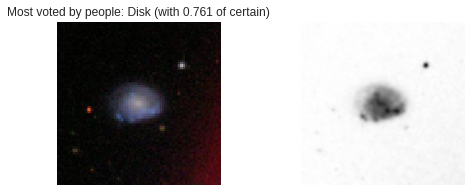

People voted: Is not a disk viewed edge-on, with 0.761423 certain
People voted: In between about the round of the galaxy, with 0.237583 certain

Expected by the model: Disk (with 0.857 of certain)
Expected by the model: Is not a disk viewed edge-on (with 0.689 of certain)
Expected by the model: In between (with 0.346 of certain)


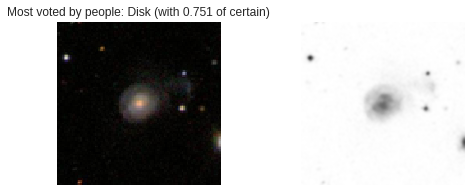

People voted: Is not a disk viewed edge-on, with 0.751261 certain
People voted: Completely round about the round of the galaxy, with 0.179329 certain

Expected by the model: Disk (with 0.806 of certain)
Expected by the model: Is not a disk viewed edge-on (with 0.667 of certain)
Expected by the model: In between (with 0.348 of certain)


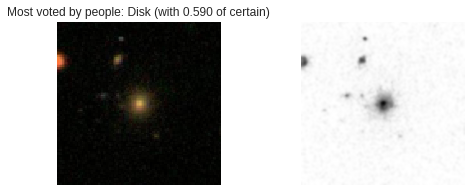

People voted: Is not a disk viewed edge-on, with 0.589990 certain
People voted: Completely round about the round of the galaxy, with 0.340233 certain

Expected by the model: Smooth (with 0.751 of certain)
Expected by the model: Is not a disk viewed edge-on (with 0.557 of certain)
Expected by the model: In between (with 0.369 of certain)


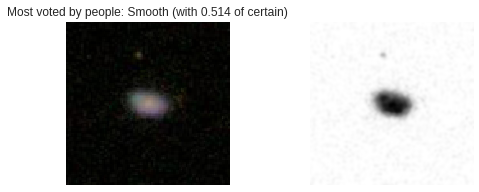

People voted: Is not a disk viewed edge-on, with 0.464511 certain
People voted: In between about the round of the galaxy, with 0.494262 certain

Expected by the model: Disk (with 0.594 of certain)
Expected by the model: Is not a disk viewed edge-on (with 0.650 of certain)
Expected by the model: In between (with 0.356 of certain)


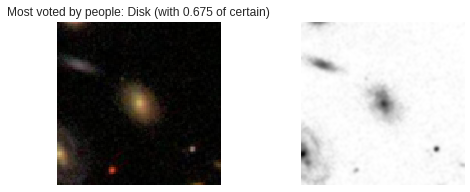

People voted: Is not a disk viewed edge-on, with 0.675178 certain
People voted: In between about the round of the galaxy, with 0.293974 certain

Expected by the model: Smooth (with 0.582 of certain)
Expected by the model: Is not a disk viewed edge-on (with 0.603 of certain)
Expected by the model: In between (with 0.363 of certain)


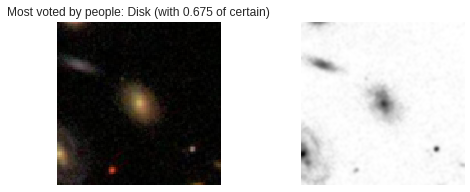

People voted: Is not a disk viewed edge-on, with 0.675178 certain
People voted: In between about the round of the galaxy, with 0.293974 certain

Expected by the model: Smooth (with 0.582 of certain)
Expected by the model: Is not a disk viewed edge-on (with 0.603 of certain)
Expected by the model: In between (with 0.363 of certain)


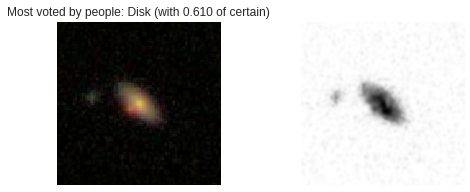

People voted: Is not a disk viewed edge-on, with 0.574934 certain
People voted: In between about the round of the galaxy, with 0.332770 certain

Expected by the model: Disk (with 0.823 of certain)
Expected by the model: Is not a disk viewed edge-on (with 0.573 of certain)
Expected by the model: In between (with 0.347 of certain)


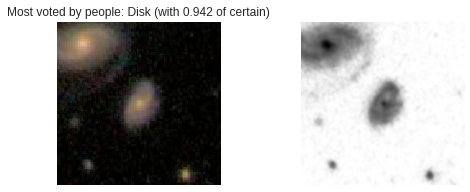

People voted: Is not a disk viewed edge-on, with 0.916392 certain
People voted: In between about the round of the galaxy, with 0.057609 certain

Expected by the model: Disk (with 0.873 of certain)
Expected by the model: Is not a disk viewed edge-on (with 0.644 of certain)
Expected by the model: In between (with 0.346 of certain)


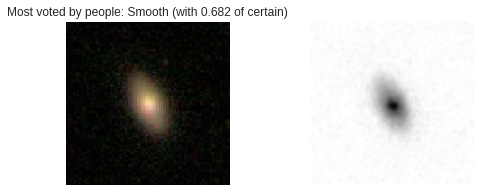

People voted: Is not a disk viewed edge-on, with 0.262356 certain
People voted: In between about the round of the galaxy, with 0.575930 certain

Expected by the model: Smooth (with 0.796 of certain)
Expected by the model: Is not a disk viewed edge-on (with 0.515 of certain)
Expected by the model: In between (with 0.371 of certain)


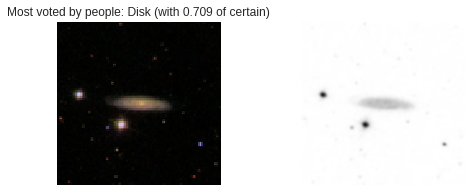

People voted: Is not a disk viewed edge-on, with 0.427010 certain
People voted: Cigar shaped about the round of the galaxy, with 0.288657 certain

Expected by the model: Disk (with 0.909 of certain)
Expected by the model: is disk viewed edge-on (with 0.578 of certain)
Expected by the model: In between (with 0.344 of certain)


In [21]:
questions_test = test_labels.iloc[:,1:].values
for i in range(10):
    visualize_outputs(X_test,questions_test,model_q1,model_q2,model_q7)

With this metodology you can go down in the tree of question to get all the 11 question anwer!.

# All the question as one output

Another approach to solve this problem is to consider all the question as independent ones, this mean Q2 doesnt depend on know the answer to Q1, so the taks is to predict all the question *simultaneously*, for this we need a network with more pottencial. As we fix a deeper network we put more regularized in it.

In [6]:
y_test = test_labels.iloc[:,1:].values
y_train = train_labels.iloc[4000:8000,1:].values 

In [6]:
#if not first train, load model
model_all = load_model('./train_models/cnn_allquestion.h5')

"""
model_all = Sequential()
model_all.add(Conv2D( 32, (3, 3) , padding='same', input_shape=X_train.shape[1:], activation='relu',kernel_regularizer=regularizers.l2(0.0005)))
model_all.add(MaxPooling2D(pool_size=(2, 2)))

model_all.add(Conv2D( 32 (3, 3), padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.0005)))
model_all.add(Conv2D( 32, (3, 3), padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.0005)))
model_all.add(MaxPooling2D(pool_size=(2, 2)))

model_all.add(Flatten())
model_all.add(Dense(264,activation='relu',kernel_regularizer=regularizers.l2(0.005)))
model_all.add(Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.005)))

model_all.add(Dense(y_test.shape[1],activation='sigmoid'))
"""

model_all.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 264)               5280264   
_________________________________________________________________
dense_2 (Dense)              (None, 128)               33920     
__________

In [8]:
model_all.compile( optimizer='rmsprop', loss='mse')

model_all.fit(X_train, y_train,batch_size=16,epochs=10,validation_data=(X_test, y_test),verbose=1)

Train on 4000 samples, validate on 2000 samples
Epoch 1/10
4000/4000 [==============================] - 144s - loss: 0.2457 - val_loss: 0.0582
Epoch 2/10
4000/4000 [==============================] - 129s - loss: 0.0563 - val_loss: 0.0556
Epoch 3/10
4000/4000 [==============================] - 129s - loss: 0.0532 - val_loss: 0.0527
Epoch 4/10
4000/4000 [==============================] - 129s - loss: 0.0525 - val_loss: 0.0528
Epoch 5/10
4000/4000 [==============================] - 129s - loss: 0.0526 - val_loss: 0.0528
Epoch 6/10
4000/4000 [==============================] - 129s - loss: 0.0525 - val_loss: 0.0527
Epoch 7/10
4000/4000 [==============================] - 129s - loss: 0.0525 - val_loss: 0.0528
Epoch 8/10
4000/4000 [==============================] - 129s - loss: 0.0526 - val_loss: 0.0528
Epoch 9/10
4000/4000 [==============================] - 129s - loss: 0.0525 - val_loss: 0.0527
Epoch 10/10
4000/4000 [==============================] - 129s - loss: 0.0525 - val_loss: 0.0527


In [8]:
#last batch
model_all.fit(X_train, y_train,batch_size=16,epochs=10,validation_data=(X_test, y_test),verbose=1)

Train on 4000 samples, validate on 2000 samples
Epoch 1/10
4000/4000 [==============================] - 132s - loss: 0.0518 - val_loss: 0.0528
Epoch 2/10
4000/4000 [==============================] - 129s - loss: 0.0518 - val_loss: 0.0527
Epoch 3/10
4000/4000 [==============================] - 129s - loss: 0.0518 - val_loss: 0.0527
Epoch 4/10
4000/4000 [==============================] - 129s - loss: 0.0518 - val_loss: 0.0527
Epoch 5/10
4000/4000 [==============================] - 129s - loss: 0.0518 - val_loss: 0.0528
Epoch 6/10
4000/4000 [==============================] - 129s - loss: 0.0518 - val_loss: 0.0528
Epoch 7/10
4000/4000 [==============================] - 129s - loss: 0.0518 - val_loss: 0.0529
Epoch 8/10
4000/4000 [==============================] - 129s - loss: 0.0518 - val_loss: 0.0528
Epoch 9/10
4000/4000 [==============================] - 129s - loss: 0.0518 - val_loss: 0.0527
Epoch 10/10
4000/4000 [==============================] - 129s - loss: 0.0518 - val_loss: 0.0527


In [9]:
#save model
model_all.save('./train_models/cnn_allquestion.h5')

Now when we have our model train in all the batch that we want we can give predict on all the questions and choose how to visualize them.

In [4]:
df_test = pd.read_csv("GalaxyZoo_kaggle/dataset_chico/test.csv.gz",header=None).values
X_test = df_test.reshape((df_test.shape[0],3,100,100))/255.0 
X_test = X_test.transpose([0,2, 3, 1])
y_test = pd.read_csv("GalaxyZoo_kaggle/dataset_chico/test_labels.csv").iloc[:,1:].values

In [14]:
columns_first_level = [0,1,2]
columns_second_level = [3,4] + [15,16,17]

print("The root mean squared error on all questions is %f"%rmse(model_all,X_test,y_test))
score = np.sqrt(mean_squared_error(y_test[:,columns_first_level],model_all.predict(X_test)[:,columns_first_level]))
print("The root mean squared error on first level (Q1) is %f"%score)
score = np.sqrt(mean_squared_error(y_test[:,columns_second_level],model_all.predict(X_test)[:,columns_second_level]))
print("The root mean squared error on only the second level(Q2/Q7) is %f"%score)
score = np.sqrt(mean_squared_error(y_test[:,columns_first_level+columns_second_level],model_all.predict(X_test)[:,columns_first_level+columns_second_level]))
print("The root mean squared error until the second level(Q1+ Q2/Q7) is %f"%score)

The root mean squared error on all questions is 0.152584
The root mean squared error on first level (Q1) is 0.204226
The root mean squared error on only the second level(Q2/Q7) is 0.210013
The root mean squared error until the second level(Q1+ Q2/Q7) is 0.207862


Here we show the RMSE on the differents level of question so it can be compared with the models before that are only trained with one output at the time.

In [28]:
from random import randint
label_names = ["Smooth","Disk","Star"]
labels_q7 = ["Completely round","In between","Cigar shaped"]
labels_q2 = ["is disk viewed edge-on", "Is not a disk viewed edge-on"]
def ver_imagen(X,Y,model):
    n = randint(0,X.shape[0])
    aux = X[n]
    canal_r = aux[:,:,0]
    canal_g = aux[:,:,1]
    canal_b = aux[:,:,2]
    
    f,ax = plt.subplots(1,2,figsize=(8,3))
    ax[0].set_title("Most voted by people: %s (with %.3f of certain)"%(label_names[np.argmax(Y[n,:3])],np.max(Y[n,:3])))

    ax[0].imshow(aux)
    ax[0].set_yticks([])
    ax[0].set_xticks([])

    ax[1].imshow(canal_r, interpolation="bicubic")
    ax[1].imshow(canal_g, interpolation="bicubic")
    ax[1].imshow(canal_b, interpolation="bicubic")
    ax[1].set_yticks([])
    ax[1].set_xticks([])
    plt.show()
    
    print("People voted: %s, with %f certain"%(labels_q2[np.argmax(Y[n,3:5])],np.max(Y[n,3:5])))
    
    print("People voted: %s about the round of the galaxy, with %f certain"%(labels_q7[np.argmax(Y[n,15:18])],np.max(Y[n,15:18])))
    print("")
    
    probabilities = model.predict(np.asarray([aux]),verbose=0)[0,:3]
    print("Expected by the model: %s (with %.3f of certain)"%(label_names[np.argmax(probabilities)],np.max(probabilities)))
    probabilities = model.predict(np.asarray([aux]),verbose=0)[0,3:5]
    print("Expected by the model: %s (with %.3f of certain)"%(labels_q2[np.argmax(probabilities)],np.max(probabilities)))
    probabilities = model.predict(np.asarray([aux]),verbose=0)[0,15:18]
    print("Expected by the model: %s (with %.3f of certain)"%(labels_q7[np.argmax(probabilities)],np.max(probabilities)))
    

Now we can visualize the prediction of the model in the first tier of question, Q1 and then Q2+Q7

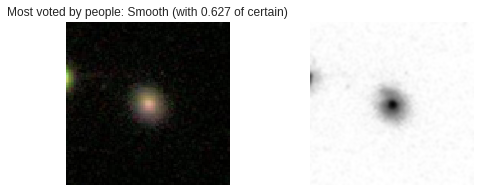

People voted: Is not a disk viewed edge-on, with 0.352930 certain
People voted: Completely round about the round of the galaxy, with 0.378210 certain

Expected by the model: Disk (with 0.648 of certain)
Expected by the model: Is not a disk viewed edge-on (with 0.534 of certain)
Expected by the model: In between (with 0.162 of certain)


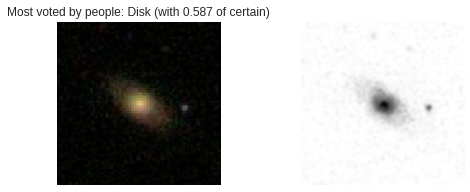

People voted: Is not a disk viewed edge-on, with 0.544023 certain
People voted: In between about the round of the galaxy, with 0.324573 certain

Expected by the model: Smooth (with 0.574 of certain)
Expected by the model: Is not a disk viewed edge-on (with 0.297 of certain)
Expected by the model: In between (with 0.254 of certain)


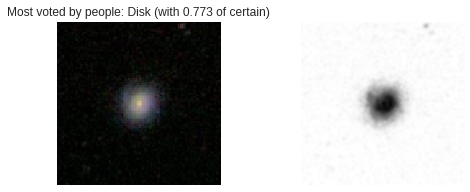

People voted: Is not a disk viewed edge-on, with 0.773303 certain
People voted: Completely round about the round of the galaxy, with 0.160231 certain

Expected by the model: Disk (with 0.716 of certain)
Expected by the model: Is not a disk viewed edge-on (with 0.607 of certain)
Expected by the model: In between (with 0.126 of certain)


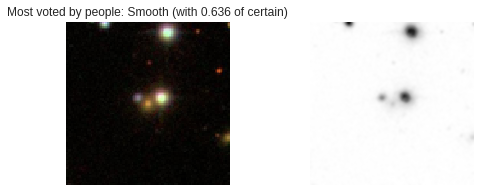

People voted: Is not a disk viewed edge-on, with 0.085624 certain
People voted: Completely round about the round of the galaxy, with 0.592120 certain

Expected by the model: Smooth (with 0.517 of certain)
Expected by the model: Is not a disk viewed edge-on (with 0.347 of certain)
Expected by the model: In between (with 0.226 of certain)


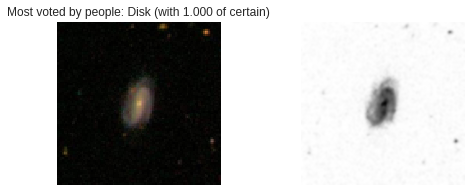

People voted: Is not a disk viewed edge-on, with 0.978065 certain
People voted: Completely round about the round of the galaxy, with 0.000000 certain

Expected by the model: Disk (with 0.689 of certain)
Expected by the model: Is not a disk viewed edge-on (with 0.579 of certain)
Expected by the model: In between (with 0.147 of certain)


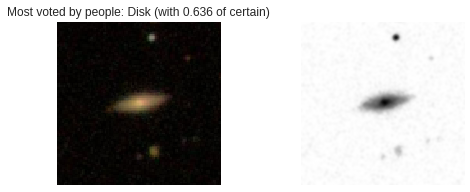

People voted: is disk viewed edge-on, with 0.415297 certain
People voted: Cigar shaped about the round of the galaxy, with 0.333423 certain

Expected by the model: Smooth (with 0.543 of certain)
Expected by the model: Is not a disk viewed edge-on (with 0.326 of certain)
Expected by the model: In between (with 0.242 of certain)


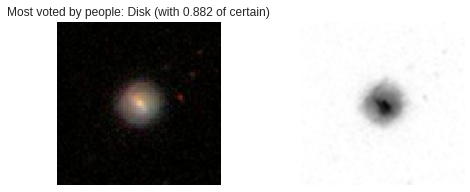

People voted: Is not a disk viewed edge-on, with 0.882258 certain
People voted: Completely round about the round of the galaxy, with 0.095130 certain

Expected by the model: Disk (with 0.683 of certain)
Expected by the model: Is not a disk viewed edge-on (with 0.571 of certain)
Expected by the model: In between (with 0.145 of certain)


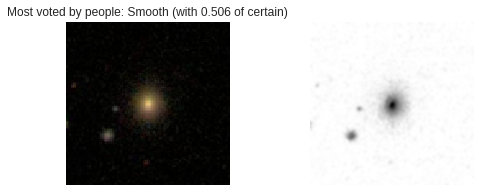

People voted: Is not a disk viewed edge-on, with 0.473514 certain
People voted: Completely round about the round of the galaxy, with 0.455210 certain

Expected by the model: Smooth (with 0.515 of certain)
Expected by the model: Is not a disk viewed edge-on (with 0.351 of certain)
Expected by the model: In between (with 0.230 of certain)


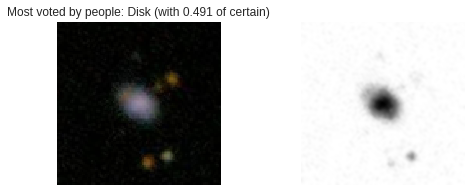

People voted: Is not a disk viewed edge-on, with 0.490727 certain
People voted: In between about the round of the galaxy, with 0.405765 certain

Expected by the model: Disk (with 0.584 of certain)
Expected by the model: Is not a disk viewed edge-on (with 0.467 of certain)
Expected by the model: In between (with 0.174 of certain)


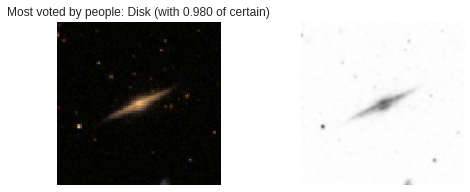

People voted: is disk viewed edge-on, with 0.980225 certain
People voted: Cigar shaped about the round of the galaxy, with 0.019775 certain

Expected by the model: Disk (with 0.547 of certain)
Expected by the model: Is not a disk viewed edge-on (with 0.433 of certain)
Expected by the model: In between (with 0.198 of certain)


In [29]:
for i in range(10):
    ver_imagen(X_test,y_test,model)

Here we can see that the model train in all the question simmultaneosly is wrong more times that the model train in only answer the first question, because it get expecialized in that question, here we train a model that predict the first question and the other question at the same time.

## Generate randomly pixel by pixel

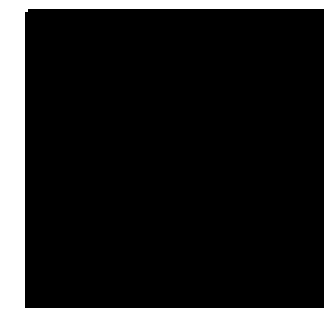

In [81]:
zeros_image = np.asarray([np.zeros((100,100)),np.zeros((100,100)),np.zeros((100,100))])
zeros_image = zeros_image.transpose(1,2,0)
zeros_image[0,0,0] = 1
zeros_image[0,0,1] = 1
zeros_image[0,0,2] = 1
plt.imshow(zeros_image)
plt.axis('off')
plt.show()

In [66]:
def softmax_A(a):
    return np.exp(a)/np.sum(np.exp(a))

In [116]:
i_want = 'Smooth'

#for 1 channel
for k in range(3):
    for i in np.arange(0,100,2):
        for j in np.arange(0,100,2):
            label_randomly = 'empty'
            while label_randomly != i_want:
                rnd = np.random.randint(100)/100.0
                zeros_image[i:i+2,j:j+2,k] = rnd
                prob = model_q1.predict(np.asarray([zeros_image]))[0]
                label_randomly = np.random.choice(['Smooth', 'Disk', 'Star'], 1,  p= softmax_A(prob))[0]
                
            print("Hizo un pixel")

Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo u

Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo u

Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo u

Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo u

Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo u

Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo u

Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo u

Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo u

Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo u

Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo u

Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo u

Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo u

Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo un pixel
Hizo u

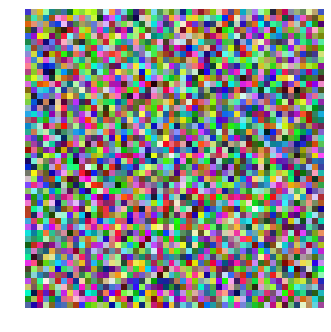

In [117]:
plt.imshow(zeros_image)
plt.axis('off')
plt.show()

## Inverse training (y -> X)

## VAE

In [3]:
### as array
#X_test = df_test.values.reshape((df_test.shape[0],3,100,100))/255.0 
X_train = df_train.values/255.0#.reshape((df_train.shape[0],3,100,100))/255.0 
X_test = df_test.values/255.0

#Transpose to tensorflow dimension, the 3 chanels are the last shape
#X_test = X_test.transpose([0,2, 3, 1])
#X_train = X_train.transpose([0,2, 3, 1])


#X_train_vector = X_train.reshape(X_train.shape[0],np.prod(X_train.shape[1:]))
#X_train_vector.shape

NameError: name 'X_train_vector' is not defined

In [4]:
import keras
from keras.layers import Input,Dense,Lambda
from keras.models import Model
from keras import backend as K

batch_size = 16
original_dim = X_train.shape[1:][0]
intermediate_dim = 1000
latent_dim = 100

/home/panshop/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
## Encoder
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

In [6]:
def sampling(args):
    epsilon_std = 1
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

In [7]:
## Decoder
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [8]:
# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [10]:
def vae_loss(x, x_decoded_mean):
    xent_loss = keras.metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)

vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (16, 30000)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (16, 1000)           30001000    input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (16, 100)            100100      dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (16, 100)            100100      dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

### train it

In [11]:
vae.fit(X_train, X_train,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,validation_data=(X_test, X_test))

Train on 4000 samples, validate on 2000 samples
Epoch 1/10
4000/4000 [==============================] - 162s 41ms/step - loss: 1005.7601 - val_loss: 0.2773
Epoch 2/10
4000/4000 [==============================] - 160s 40ms/step - loss: 0.3731 - val_loss: 0.1539
Epoch 3/10
4000/4000 [==============================] - 161s 40ms/step - loss: 0.1465 - val_loss: 0.1449
Epoch 4/10
4000/4000 [==============================] - 161s 40ms/step - loss: 0.1455 - val_loss: 0.1445
Epoch 5/10
4000/4000 [==============================] - 161s 40ms/step - loss: 0.1456 - val_loss: 0.1445
Epoch 6/10
4000/4000 [==============================] - 161s 40ms/step - loss: 0.1455 - val_loss: 0.1448
Epoch 7/10
4000/4000 [==============================] - 160s 40ms/step - loss: 0.1456 - val_loss: 0.1446
Epoch 8/10
4000/4000 [==============================] - 161s 40ms/step - loss: 0.1455 - val_loss: 0.1448
Epoch 9/10
4000/4000 [==============================] - 161s 40ms/step - loss: 0.1457 - val_loss: 0.1449
Epoc

### test it

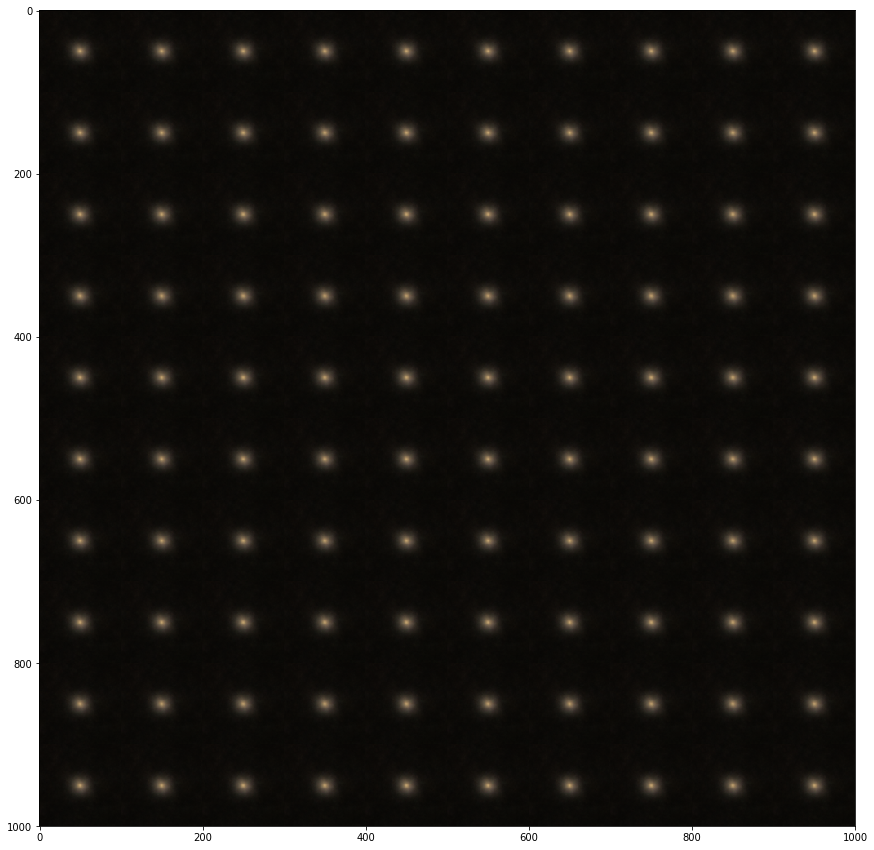

In [13]:
epsilon_std = 1
n = 10  # figure with 15x15 images
image_size = 100
figure = np.zeros((image_size * n, image_size * n,3))

#grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
#grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

from scipy.stats import norm
for i in range(n):
    for j in range(n):
        zmean_random = norm.rvs(100)#norm.ppf(np.linspace(0.05, 0.95, 100))
        zlogsigma_random = norm.rvs(100) #norm.ppf(np.linspace(0.05, 0.95, 100))
        z_sample = np.array([zmean_random, zlogsigma_random])
        
        x_decoded = generator.predict(z_sample)
        
        image = x_decoded[0].reshape(3,image_size, image_size)
        image = image.transpose([1,2,0])
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size,:] = image

plt.figure(figsize=(15, 15))
plt.imshow(figure)
plt.show()

### VAE convolutional

In [4]:
### as array
X_test = df_test.values.reshape((df_test.shape[0],3,100,100))/255.0 
X_train = df_train.values.reshape((df_train.shape[0],3,100,100))/255.0 

#Transpose to tensorflow dimension, the 3 chanels are the last shape
X_test = X_test.transpose([0,2, 3, 1])
X_train = X_train.transpose([0,2, 3, 1])

In [5]:
import keras
from keras.layers import Input,Dense,Lambda,Flatten,Conv2D,Conv2DTranspose,Reshape
from keras.models import Model
from keras import backend as K

# input image dimensions
img_rows, img_cols, img_chns = 100, 100, 3
original_img_size = (img_rows, img_cols,img_chns)

# number of convolutional filters to use
filters = 32
# convolution kernel size
num_conv = 3
batch_size = 10

latent_dim = 32
intermediate_dim = 256
epsilon_std = 1.0
epochs = 10

In [6]:
## Encoder
x = Input(shape=original_img_size)
conv_1 = Conv2D(filters,kernel_size=(2, 2),padding='same', activation='relu',strides=(2, 2))(x)
conv_2 = Conv2D(filters*2, kernel_size=(2, 2),padding='same', activation='relu',strides=1)(conv_1)
#conv_3 = Conv2D(filters, kernel_size=num_conv, padding='same', activation='relu', strides=1)(conv_2)
conv_4 = Conv2D(filters*3,kernel_size=num_conv, padding='same', activation='relu', strides=(2,2))(conv_2)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)

z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)

In [7]:
def sampling(args):
    epsilon_std = 1.0
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_var])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [8]:
## Decoder

# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(filters*3 * img_rows/4 * img_cols/4, activation='relu')

output_shape = (batch_size, img_rows/4, img_cols/4, filters*3)
decoder_reshape = Reshape(output_shape[1:])

decoder_deconv_1 = Conv2DTranspose(filters*2,kernel_size=num_conv,padding='same',strides=(2,2), activation='relu')
#decoder_deconv_2 = Conv2DTranspose(filters,kernel_size=num_conv,padding='same',strides=1, activation='relu')

output_shape = (batch_size, 29, 29, filters)
#decoder_deconv_3_upsamp = Conv2DTranspose(filters,kernel_size=(3, 3),strides=(2, 2), padding='valid',activation='relu')
decoder_deconv_3_upsamp = Conv2DTranspose(filters,kernel_size=(2, 2),strides=1, padding='same',activation='relu')

decoder_mean_squash = Conv2DTranspose(img_chns, kernel_size=(2,2), strides=(2,2),padding='valid', activation='sigmoid')

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
#deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
x_decoded_relu = decoder_deconv_3_upsamp(deconv_1_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)

In [9]:
# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)

# Compute VAE loss
xent_loss = keras.metrics.binary_crossentropy(
    K.flatten(x),
    K.flatten(x_decoded_mean_squash))
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)
vae.add_loss(vae_loss)

vae.compile(optimizer='rmsprop')
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 50, 32)   416         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 50, 50, 64)   8256        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 25, 25, 96)   55392       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 

/home/panshop/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Output "conv2d_transpose_3" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_transpose_3" during training.
  if sys.path[0] == '':


In [10]:
vae.fit(X_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, None))

Train on 4000 samples, validate on 2000 samples
Epoch 1/10
4000/4000 [==============================] - 215s 54ms/step - loss: 0.1638 - val_loss: 0.1471
Epoch 2/10
4000/4000 [==============================] - 173s 43ms/step - loss: 0.1473 - val_loss: 0.1495
Epoch 3/10
4000/4000 [==============================] - 178s 44ms/step - loss: 0.1464 - val_loss: 0.1454
Epoch 4/10
4000/4000 [==============================] - 174s 44ms/step - loss: 0.1459 - val_loss: 0.1449
Epoch 5/10
1080/4000 [=======>......................] - ETA: 2:00 - loss: 0.1455

KeyboardInterrupt: 

### Test it

In [11]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
#_deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_relu = decoder_deconv_3_upsamp(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)

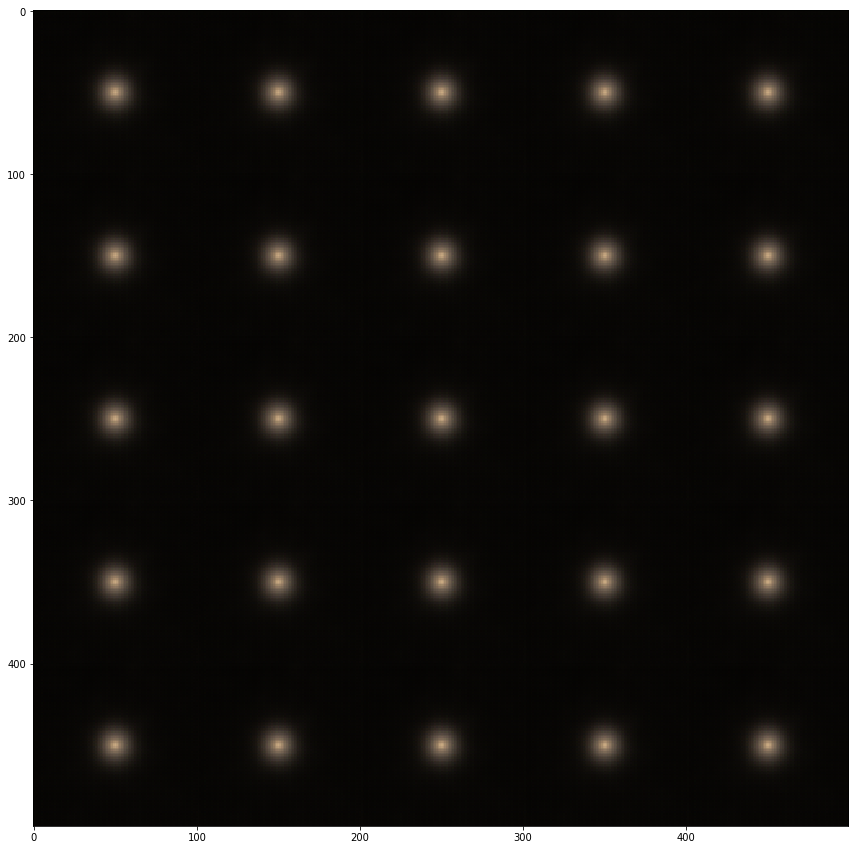

In [14]:
n = 5  # figure with 15x15 images
image_size = 100
figure = np.zeros((image_size * n, image_size * n,3))

from scipy.stats import norm
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

#grid_x = np.linspace(-15, 15, n)
#grid_y = np.linspace(-15, 15, n)
        
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        #zmean_random = np.random.rand(1)*30-15
        #zlogsigma_random = np.random.rand(1)*30-15
        #z_sample = np.array([[zmean_random, zlogsigma_random]])
        
        a = norm.ppf(np.linspace(0.05, 0.95, 32))
        b = norm.ppf(np.linspace(0.05, 0.95, 32))
        
        z_sample = np.array([a,b])
        
        #z_sample = np.array([[xi, yi]])

        #z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
            
        
        x_decoded = generator.predict(z_sample,batch_size=batch_size)
        
        #image = x_decoded[0].reshape(3,image_size, image_size)
        #image = image.transpose([1,2,0])
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size,:] = x_decoded[0]

plt.figure(figsize=(15, 15))
plt.imshow(figure)
plt.show()

## GAN 
https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0

In [51]:
### as array
X_test = df_test.values.reshape((df_test.shape[0],3,100,100))/255.0 
X_train = df_train.values.reshape((df_train.shape[0],3,100,100))/255.0 

#Transpose to tensorflow dimension, the 3 chanels are the last shape
X_test = X_test.transpose([0,2, 3, 1])
X_train = X_train.transpose([0,2, 3, 1])

In [17]:
from keras.layers import LeakyReLU
## Discriminator
D = Sequential()
depth = 64
dropout = 0.4
# In: 28 x 28 x 1, depth = 1
# Out: 14 x 14 x 1, depth=64
img_rows = img_cols = 100
channel=3
input_shape = (img_rows, img_cols, channel)
D.add(Conv2D(depth*1, (5,5), strides=2, input_shape=input_shape,padding='same', activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Conv2D(depth*2, (5,5), strides=2, padding='same',activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Conv2D(depth*4, (5,5), strides=2, padding='same',activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Conv2D(depth*8, (5,5), strides=1, padding='same',activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
# Out: 1-dim probability
D.add(Flatten())
D.add(Dense(1))
D.add(Activation('sigmoid'))
D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 50, 50, 64)        4864      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 25, 25, 128)       204928    
_________________________________________________________________
dropout_7 (Dropout)          (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 256)       819456    
_________________________________________________________________
dropout_8 (Dropout)          (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 512)       3277312   
__________

In [5]:
from keras.layers import BatchNormalization,Reshape,UpSampling2D,Conv2DTranspose

## Generator
G = Sequential()
dropout = 0.4
#layers = 4
dim = 25 #img_cols/layers
depth = 64*4
#_,dim,dim,depth = D.layers[-5].output_shape #for tensorflow dim #64+64+64+64
# In: 100
# Out: dim x dim x depth
G.add(Dense(dim*dim*depth, input_dim=100))
G.add(BatchNormalization(momentum=0.9))
G.add(Activation('relu'))
G.add(Reshape((dim, dim, depth)))
G.add(Dropout(dropout))
# In: dim x dim x depth
# Out: 2*dim x 2*dim x depth/2
G.add(UpSampling2D())
G.add(Conv2DTranspose(int(depth/2), (5,5), padding='same'))
G.add(BatchNormalization(momentum=0.9))
G.add(Activation('relu'))
G.add(UpSampling2D())
G.add(Conv2DTranspose(int(depth/4), (5,5), padding='same'))
G.add(BatchNormalization(momentum=0.9))
G.add(Activation('relu'))
#G.add(UpSampling2D())
G.add(Conv2DTranspose(int(depth/8), (5,5), padding='same'))
G.add(BatchNormalization(momentum=0.9))
G.add(Activation('relu'))
# Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
G.add(Conv2DTranspose(channel, (5,5), padding='same'))
G.add(Activation('sigmoid'))
G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 160000)            16160000  
_________________________________________________________________
batch_normalization_1 (Batch (None, 160000)            640000    
_________________________________________________________________
activation_2 (Activation)    (None, 160000)            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 25, 25, 256)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 25, 25, 256)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 50, 50, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 50, 50, 128)       819328    
__________

In [18]:
from keras.optimizers import RMSprop
## Discriminator model (police)
optimizer = RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8)
DM = Sequential()
DM.add(D)
DM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])

In [19]:
## Adversarial model (Generator->Discriminator)
D.trainable=False #set the discriminator fixed params
optimizer = RMSprop(lr=0.0004, clipvalue=1.0, decay=3e-8)
AM = Sequential()
AM.add(G)
AM.add(D)
AM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
AM.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 100, 100, 3)       17878723  
_________________________________________________________________
sequential_6 (Sequential)    (None, 1)                 4393089   
Total params: 22,271,812
Trainable params: 21,951,364
Non-trainable params: 320,448
_________________________________________________________________


### Train it

In [69]:
batch_size=8
#sample images from real data
images_train = X_train[np.random.randint(0,X_train.shape[0], size=batch_size), :, :, :]

#sample image from generated data
noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
images_fake = G.predict(noise) #se actualizara por ref?

x = np.concatenate((images_train, images_fake))

#create labels
y = np.ones([2*batch_size, 1])
y[batch_size:, :] = 0

#train discriminator
d_loss = DM.train_on_batch(x, y)

#train generator (or adversarial)
y = np.ones([batch_size, 1])
noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
a_loss = AM.train_on_batch(noise, y)

ResourceExhaustedError: OOM when allocating tensor with shape[256,128,5,5] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: sequential_28_1/conv2d_19/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](sequential_28_1/dropout_26/cond/Merge, conv2d_19/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: metrics_4/acc/Mean_1/_1659 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2910_metrics_4/acc/Mean_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op u'sequential_28_1/conv2d_19/convolution', defined at:
  File "/home/panshop/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/panshop/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/panshop/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/panshop/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/panshop/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/home/panshop/anaconda2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/panshop/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/panshop/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/panshop/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/panshop/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/panshop/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/panshop/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/panshop/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/panshop/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/panshop/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/panshop/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/panshop/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/panshop/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/panshop/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/panshop/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-49-8f9ac7be1c86>", line 5, in <module>
    AM.add(D)
  File "/home/panshop/anaconda2/lib/python2.7/site-packages/keras/models.py", line 492, in add
    output_tensor = layer(self.outputs[0])
  File "/home/panshop/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py", line 617, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/panshop/anaconda2/lib/python2.7/site-packages/keras/models.py", line 549, in call
    return self.model.call(inputs, mask)
  File "/home/panshop/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py", line 2081, in call
    output_tensors, _, _ = self.run_internal_graph(inputs, masks)
  File "/home/panshop/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py", line 2232, in run_internal_graph
    output_tensors = _to_list(layer.call(computed_tensor, **kwargs))
  File "/home/panshop/anaconda2/lib/python2.7/site-packages/keras/layers/convolutional.py", line 168, in call
    dilation_rate=self.dilation_rate)
  File "/home/panshop/anaconda2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py", line 3332, in conv2d
    data_format=tf_data_format)
  File "/home/panshop/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/nn_ops.py", line 781, in convolution
    return op(input, filter)
  File "/home/panshop/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/nn_ops.py", line 869, in __call__
    return self.conv_op(inp, filter)
  File "/home/panshop/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/nn_ops.py", line 521, in __call__
    return self.call(inp, filter)
  File "/home/panshop/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/nn_ops.py", line 205, in __call__
    name=self.name)
  File "/home/panshop/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 631, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "/home/panshop/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/panshop/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 3271, in create_op
    op_def=op_def)
  File "/home/panshop/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[256,128,5,5] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: sequential_28_1/conv2d_19/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](sequential_28_1/dropout_26/cond/Merge, conv2d_19/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: metrics_4/acc/Mean_1/_1659 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2910_metrics_4/acc/Mean_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
noise_input = None
if save_interval>0:
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
for i in range(train_steps):
    images_train = self.x_train[np.random.randint(0,
        self.x_train.shape[0], size=batch_size), :, :, :]
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
    images_fake = self.generator.predict(noise)
    x = np.concatenate((images_train, images_fake))
    y = np.ones([2*batch_size, 1])
    y[batch_size:, :] = 0
    d_loss = self.discriminator.train_on_batch(x, y)

    y = np.ones([batch_size, 1])
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
    a_loss = self.adversarial.train_on_batch(noise, y)
    log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
    log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
    print(log_mesg)
    if save_interval>0:
        if (i+1)%save_interval==0:
            self.plot_images(save2file=True, samples=noise_input.shape[0],\
                noise=noise_input, step=(i+1))

### Test it

In [ ]:
filename = 'mnist.png'
if fake:
    if noise is None:
        noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
    else:
        filename = "mnist_%d.png" % step
    images = self.generator.predict(noise)
else:
    i = np.random.randint(0, self.x_train.shape[0], samples)
    images = self.x_train[i, :, :, :]

plt.figure(figsize=(10,10))
for i in range(images.shape[0]):
    plt.subplot(4, 4, i+1)
    image = images[i, :, :, :]
    image = np.reshape(image, [self.img_rows, self.img_cols])
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.tight_layout()
if save2file:
    plt.savefig(filename)
    plt.close('all')
else:
    plt.show()